In [1]:
"""
model: Neural Language Models (Bengio et al. 2003) URL: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Dimension key:
# windows
B: batch size
T: sequence length

# input/output
V: vocabulary size
E: embedding dimension
D: model dimension
"""
import torch
# from jaxtyping import ...
g = torch.Generator().manual_seed(1337) # for .randn()

B, T = 32, 3
V, E, D = 27, 10, 200

# step: 0/200000, loss 27.63208770751953
# -> expected loss = nll = p(c) = -torch.tensor(1/V=27).log() = 3.2958
# -> self.W = torch.randn() is sampling from N(0, 1)

class Linear:
    def __init__(self, D_in, D_out, bias=True):
        self.W_DiDo = torch.randn((D_in, D_out), generator=g) * 0.01 # / D**0.5
        self.b_Do = torch.zeros(D_out) if bias else None

    def __call__(self, X_Di):
        self.X_Do = X_Di @ self.W_DiDo
        if self.b_Do is not None:
            self.X_Do += self.b_Do
            self.out = self.X_Do
        return self.X_Do

    def parameters(self):
        return [self.W_DiDo] + ([] if self.b_Do is None else [self.b_Do])

class Tanh:
    def __call__(self, X_D):
        self.X_D = torch.tanh(X_D)
        self.out = X_D
        return self.X_D
    
    def parameters(self):
        return []

model = [
    Linear(T * E, D), Tanh(),
    Linear(D, D), Tanh(),
    Linear(D, V),
]

C = torch.randn((V,E), generator=g)
params = [C] + [p for l in model for p in l.parameters()]
for p in params:
    p.requires_grad = True

step: 0/200000, loss 3.2958412170410156
step: 10000/200000, loss 2.8608055114746094
step: 20000/200000, loss 2.5654854774475098
step: 30000/200000, loss 2.393764019012451
step: 40000/200000, loss 2.203112840652466
step: 50000/200000, loss 2.903104305267334
step: 60000/200000, loss 2.1081087589263916
step: 70000/200000, loss 1.8697260618209839
step: 80000/200000, loss 2.0619494915008545
step: 90000/200000, loss 2.1460368633270264
step: 100000/200000, loss 2.3474557399749756
step: 110000/200000, loss 2.2977802753448486
step: 120000/200000, loss 2.1856257915496826
step: 130000/200000, loss 2.3124732971191406
step: 140000/200000, loss 1.9921398162841797
step: 150000/200000, loss 2.034698963165283
step: 160000/200000, loss 1.9852980375289917
step: 170000/200000, loss 2.4496588706970215
step: 180000/200000, loss 2.0552587509155273
step: 190000/200000, loss 2.0114927291870117


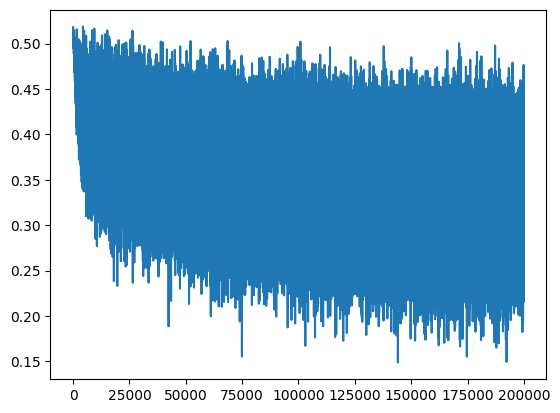

In [2]:
# 1. dataloader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random

words = open('./data/names.txt', 'r').read().splitlines()
v = sorted(list(set(''.join(words))))
encode = { c:i+1 for i,c in enumerate(v) }
encode['.'] = 0
decode = { i:c for c,i in encode.items() }

context_length = 3
def gen_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * context_length;
        for c in w + '.':
            X.append(context)
            Y.append(encode[c])
            # print(''.join(decode[i] for i in context), '-->', decode[encode[c]])
            context = context[1:] + [encode[c]]
    X, Y = torch.tensor(X), torch.tensor(Y) # X:(N,C) Y:(N)
    return X, Y

random.seed(42)
random.shuffle(words)
n1, n2 = int(0.8*len(words)), int(0.9*len(words))
Xtr, Ytr = gen_dataset(words[:n1])
Xdev, Ydev = gen_dataset(words[n1:n2])
Xte, Yte = gen_dataset(words[n2:])

# 2. training loop
N = Xtr.shape[0]
losses, steps = [], []
for step in range(200000):
    # h1preact =  embcat @ W1 + b1
    # h1preact = bngain * (h1preact - h1preact.mean(0, keepdim=True)) / h1preact.std(0, keepdim=True) + bnbias
    # h1 = torch.tanh(h1preact) # (-1=32,3,2)->(N:32,C*E:6) @ (C*E:6,100) = (32,100)
    # logits = (h1 @ W2) + b2 # R (32,100) @ (100,27) + (1,27) = (32,27)

    # 1. forward
    ix_mini = torch.randint(0, N, (B,))
    X_B, Y_B = Xtr[ix_mini], Ytr[ix_mini]

    embcat = C[X_B].view(-1, T * E)
    x = embcat
    for l in model:
        x = l(x)
    loss = F.cross_entropy(x, Y_B)

    # 2. backward
    for l in model:
        l.out.retain_grad()
    for p in params:
        p.grad = None
    loss.backward()

    # 3. update
    for p in params:
        p.data += -0.01 * p.grad

    steps.append(step)
    losses.append(loss.log10().item())
    if step % 10000 == 0:
        print(f"step: {step}/{200000}, loss {loss.item()}")

plt.plot(steps, losses)

# embcat = C[Xtr].view(-1,context_length * n_embd)
# h1preact =  embcat @ W1 + b1
# h1preact = bngain * (h1preact - h1preact.mean(0, keepdim=True)) / h1preact.std(0, keepdim=True) + bnbias
# h1 = torch.tanh(h1preact) # (-1=32,3,2)->(N:32,C*E:6) @ (C*E:6,100) = (32,100)
# logits = (h1 @ W2) + b2 # R (32,100) @ (100,27) + (1,27) = (32,27)
# loss = F.cross_entropy(logits, Ytr) # fused kernels, numerical stability
# print("loss_train", loss.item())

# embcat = C[Xdev].view(-1,context_length * n_embd)
# h1preact =  embcat @ W1 + b1
# h1preact = bngain * (h1preact - h1preact.mean(0, keepdim=True)) / h1preact.std(0, keepdim=True) + bnbias
# h1 = torch.tanh(h1preact) # (-1=32,3,2)->(N:32,C*E:6) @ (C*E:6,100) = (32,100)
# logits = (h1 @ W2) + b2 # R (32,100) @ (100,27) + (1,27) = (32,27)
# loss = F.cross_entropy(logits, Ydev) # fused kernels, numerical stability
# print("loss_val", loss.item())

# generalization
# @torch.no_grad() # this decorator disables gradient tracking
# def split_loss(split):
#   x,y = {
#     'train': (Xtr, Ytr),
#     'val': (Xdev, Ydev),
#     'test': (Xte, Yte),
#   }[split]
#   emb = C[x] # (N, block_size, n_embd)
#   x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
#   for layer in layers:
#     x = layer(x)
#   loss = F.cross_entropy(x, y)
#   print(split, loss.item())

# # put layers into eval mode
# for layer in layers:
#   layer.training = False
# split_loss('train')
# split_loss('val')

In [4]:
# inference loop
i_terminal = 0
for _ in range(20):
    output = []
    context = [0] * context_length
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        for l in model:
          x = l(x)
        logits = x
        y_hat = F.softmax(logits, dim=1)

        i = torch.multinomial(y_hat, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [i]
        output.append(decode[i])
        if i == i_terminal:
            break
    print(''.join(output))

len.
ryluz.
kobben.
aesabaraivorylahnura.
camiluhaina.
aire.
luxiina.
rayvieonna.
maxtiara.
wiam.
jok.
red.
malimari.
peditra.
leigenstie.
wideya.
aur.
erins.
adon.
lam.
